In [ ]:
import os
import sys
import json
import copy
import mmcv
import cv2
import torch
import tqdm
import numpy as np
import pickle as pkl
from fvcore.common.file_io import PathManager
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from slowfast.datasets.ava_helper import parse_bboxes_file
from slowfast.visualization.video_visualizer import VideoVisualizer
from slowfast.datasets.cv2_transform import scale, scale_boxes, revert_scaled_boxes
from slowfast.utils.ava_eval_helper import (
    make_image_key,
    read_labelmap,
)
from slowfast.datasets import cv2_transform
from slowfast.datasets.utils import tensor_normalize


root_dir = '/n/fs/vai-bwc-scr/'
vid_dir = os.path.join(root_dir, 'videos/')
out_dir = os.path.join(root_dir, 'action_detection/outputs/')

# Police Body-worn Camera Action annotations 
POBCA_PATH = os.path.join(root_dir, 'action_detection/annotations/audit.json')
# Slowfast predictions path
PREDS_PATH = os.path.join(root_dir, 'action_detection/annotations/bwc_frames_shifted.csv')
AVA_CLS = os.path.join(root_dir, 'action_detection/slowfast/demo/AVA/ava_classnames.json')


In [2]:
def load_boxes_labels(video_name, preds_boxes_path, total_frames=0, action_span=0):
    """
    Loading boxes and labels from AVA bounding boxes csv files.
    Args:
        video_name (str): name of the given video.
        preds_boxes_path  (str): path to predicted boxes file (csv)
    Returns:
        preds_boxes (dict): a dict which maps from `frame_idx` to a list of `boxes`
            and `labels`. Each `box` is a list of 4 box coordinates. `labels[i]` is
            a list of labels for `boxes[i]`. Note that label is -1 for predicted boxes.
    """
    def process_bboxes_dict(dictionary, total_frames, action_span):
        """ 
        merge all [`box_coordinate`, `box_labels`] pairs into
        [`all_boxes_coordinates`, `all_boxes_labels`] for each `keyframe_idx`.
        Args:
            dictionary (dict): a dictionary which maps `frame_idx` to a list of `box`.
                Each `box` is a [`box_coord`, `box_labels`] where `box_coord` is the
                coordinates of box and 'box_labels` are the corresponding
                labels for the box.
        Returns:
            new_dict (dict): a dict which maps from `frame_idx` to a list of `boxes`
                and `labels`. Each `box` in `boxes` is a list of 4 box coordinates. `labels[i]`
                is a list of labels for `boxes[i]`. Note that label is -1 for predicted boxes.
        """
        new_dict = {}
        for keyframe_idx, boxes_and_labels in dictionary.items():
            # Ignore keyframes with no boxes
            if len(boxes_and_labels) == 0:
                continue
            boxes, labels = list(zip(*boxes_and_labels))
            boxes = np.array(boxes)
            new_dict[keyframe_idx] = [boxes.tolist(), list(labels)]
            for i in range(action_span):
                before = max(0, keyframe_idx-i-1)
                after = min(total_frames, keyframe_idx+i+1)
                if before not in new_dict:    
                    new_dict[before] = [boxes.tolist(), list(labels)]
                if after not in new_dict:
                    new_dict[after] = [boxes.tolist(), list(labels)]
        return new_dict

    preds_boxes, _, _ = parse_bboxes_file(
        ann_filenames=[preds_boxes_path],
        ann_is_gt_box=[False],
        detect_thresh=0.9,
        boxes_sample_rate=1,
    )
    preds_boxes = preds_boxes[video_name]
    preds_boxes = process_bboxes_dict(preds_boxes, total_frames, action_span)

    return preds_boxes


    

def draw_preds(video_name, preds_boxes_path, out_dir):

    vid_path = os.path.join(vid_dir, video_name)                                                                                                                  
    video = mmcv.VideoReader(vid_path)
    fps = round(video.fps)
    dim = (video.width, video.height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    #cap = cv2.VideoCapture(vid_path)
    #total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    overlay_path = os.path.join(out_dir, video_name[:-4].replace(' ', '_')+'_preds'+'.mp4') 
    overlay_tracked = cv2.VideoWriter(overlay_path, fourcc, fps, dim)
    
    # num frames to spread detected boxes across before and after detected frame
    action_span = 15
    # get predicted boxes and labels
    pred_boxes = load_boxes_labels(video_name[:-4], preds_boxes_path, len(video), action_span)

    # get AVA visualizer for display
    common_classes = (
            ["watch (a person)",
             "talk to (e.g., self, a person, a group)",
             "listen to (a person)",
             "touch (an object)",
             "carry/hold (an object)",
             "walk",
             "sit",
             "lie/sleep",
             "bend/bow (at the waist)"]
    )
    video_vis = VideoVisualizer(
        num_classes=400,
        class_names_path=AVA_CLS,
        top_k=3,
        thres=0.7,
        lower_thres=0.3,
        common_class_names=common_classes,
        colormap="Pastel2",
        mode="top-k",
    )

    #all_keys = sorted(merged_boxes.keys())

    for frame_id in range(len(video)):
        frame = video[frame_id]      
        if frame_id in pred_boxes:
            # get predicted boxes and labels for frame
            pred_boxes_frame = pred_boxes[frame_id]
            bboxes = pred_boxes_frame[0]
            label = pred_boxes_frame[1]
            
            # scale to video size
            bboxes = revert_scaled_boxes(256, np.array(bboxes), video.height, video.width)
                    
            # Draw predictions.
            frame = video_vis.draw_one_frame(
                frame,
                torch.Tensor(label),
                bboxes=torch.Tensor(bboxes))
            
        overlay_tracked.write(frame)
   
        
    overlay_tracked.release()


In [ ]:
draw_preds('AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP 415.mp4', PREDS_PATH, out_dir)

In [3]:
def get_labels(labelAttrs):
    labels = []
    for i in labelAttrs:
        if type(i['value']) is list:
            for value in i['value']:    
                labels.append(value)
        else:
            labels.append(i['value']) 
    return ', '.join(labels)

def overlay_bwc_annos(vid_dict, out_dir):
    title = vid_dict['data']['image_url'][0].split('/')[0]
    if 'AXON' in title:
        title = title[:-4]+' 415.mp4'
    else:
        title = title.replace('_',  ' ')+'.mp4'

    vid_path = os.path.join(vid_dir, title)                                                                                                                  
    video = mmcv.VideoReader(vid_path)
    fps = round(video.fps)
    dim = (video.width, video.height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    overlay_path = os.path.join(out_dir, title[:-4].replace(' ', '_')+'_anno_overlay'+'.mp4') 
    overlay_tracked = cv2.VideoWriter(overlay_path, fourcc, fps, dim)
    
    frame_bbox_dict = {}
    for bbox in vid_dict['result']['data']:
        frame = int(bbox['frame'])*fps
        if frame in frame_bbox_dict:
            frame_bbox_dict[frame].append(bbox)
        else:
            frame_bbox_dict[frame] = [bbox]
    
    for frame_id in range(len(video)):
        frame = video[frame_id]      
        if frame_id in frame_bbox_dict:
            canvas = copy.deepcopy(frame)
            for bbox in frame_bbox_dict[frame_id]:
                start = (int(bbox['coordinate'][0]['x']), int(bbox['coordinate'][0]['y']))
                end = (int(bbox['coordinate'][2]['x']), int(bbox['coordinate'][2]['y']))
                color = (255,0,0)
                cv2.rectangle(canvas, start, end, color, 1)
                cv2.putText(canvas, get_labels(bbox['labelAttrs']), start, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            frame = canvas
        
        overlay_tracked.write(frame)
        
    overlay_tracked.release()
    
def alert_bwc_annos(vid_dict):
    orig_title = vid_dict['data']['image_url'][0].split('/')[0]
    if 'AXON' in orig_title:
        title = orig_title[:-4]+' 415.mp4'
    else:
        title = orig_title.replace('_',  ' ')+'.mp4'

    vid_path = os.path.join(vid_dir, title)                                                                                                                  
    video = mmcv.VideoReader(vid_path)
    fps = round(video.fps)
    dim = (video.width, video.height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    frame_bbox_dict = {}
    for bbox in vid_dict['result']['data']:
        frame = int(bbox['frame'])*fps
        if frame in frame_bbox_dict:
            frame_bbox_dict[frame].append(bbox)
        else:
            frame_bbox_dict[frame] = [bbox]
            
    feat_path = '/n/fs/vai-bwc-scr/action_detection/annotations/alert_features.pkl'
    if os.path.exists(feat_path):
        with open(feat_path,'rb') as f: 
            alert_features_dict = pkl.load(f)
    
    for frame_id in range(len(video)):
        frame = video[frame_id]      
        if frame_id in frame_bbox_dict:
            frame_sec = round(frame_id/fps)
            key = make_image_key(orig_title, frame_sec)
            #if key not in alert_features_dict:
            frame_t = cv2_transform.scale(256, frame)
            frame_t = torch.from_numpy(np.array(frame)).float() / 255
            mean, std = frame_t.mean([0,1]), frame_t.std([0,1])
            frame_t = tensor_normalize(frame_t, mean, std)
            alert_features_dict[key] = frame_t.numpy().flatten()
                
                
    with PathManager.open(feat_path, 'wb') as f:
        pkl.dump(alert_features_dict, f)
    

In [6]:
with open(POBCA_PATH) as f:                                                                                                                                                       
    bwc_annos = json.load(f)
    
for vid in bwc_annos:
    #overlay_bwc_annos(vid, out_dir)
    alert_bwc_annos(vid)
    

In [ ]:
def concat_vids(vid1, vid2, out_dir): 
    title = vid1[:-10]
    vid1 = os.path.join(out_dir, vid1)
    vid2 = os.path.join(out_dir, vid2)
    vid1 = mmcv.VideoReader(vid1)
    vid2 = mmcv.VideoReader(vid2)
    fps = round(vid1.fps)
    dim = (vid1.width*2, vid1.height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    video_path = os.path.join(out_dir, title+'_concat.mp4') 
    video_tracked = cv2.VideoWriter(video_path, fourcc, fps, dim)

    
    for frame_id in range(len(vid1)):
        if frame_id % fps == 0:
            frame1 = vid1[frame_id] 
            frame2 = vid2[frame_id]
            new_frame = cv2.hconcat([frame1, frame2])
        video_tracked.write(new_frame)
        
    video_tracked.release()

In [6]:
concat_vids('AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP_415_preds.mp4','AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP_415_anno_overlay.mp4', out_dir)
#concat_vids('Body-Cam_Video_#1_preds.mp4','Body-Cam_Video_#1_anno_overlay.mp4', out_dir)
#concat_vids('BC3_slowfast_output.mp4','Body-Cam_Video_#3_anno_overlay.mp4', out_dir)

In [8]:
def get_classes(path):
        try:
            with PathManager.open(path, "r") as f:
                class2idx = json.load(f)
                return class2idx
        except Exception as err:
            print("Fail to load file from {} with error {}".format(path, err))
            return

def action_color_bar(action, ava_cls_idx, video_name, gt_boxes, pred_boxes, num_frames):   
    frame_action_dict = {}
    fps = 30
    fig, ax = plt.subplots(2, 1)
    for bbox in gt_boxes['result']['data']:
        for label in bbox['labelAttrs']:
                if len(label['value']) != 0:
                    for label_val in label['value']:
                        if action in label_val.lower():
                            frame_action_dict[int(bbox['frame'])] = 1
                            ax[0].add_patch(Rectangle((int(bbox['frame']), 0), 1, 1, color='green'))
                            break
        if int(bbox['frame']) not in frame_action_dict:
            frame_action_dict[int(bbox['frame'])] = 0
            
    for frame in pred_boxes:
        pred_score = float(pred_boxes[frame][1][0][ava_cls_idx])
        if pred_score > 0.1:
            ax[1].add_patch(Rectangle((int(frame)/fps, 0), 1, 1, color='green', alpha=pred_score))         
            
    ax[0].set_xlim((0, num_frames))
    ax[1].set_xlim((0, num_frames))
    ax[0].set_xlabel("frame (1 per sec)")
    ax[1].set_xlabel("frame (1 per sec)")
    ax[0].set_title('Annotated occurances of ' + action + ' in ' + video_name)
    ax[1].set_title('Detected occurances of ' + action + ' in ' + video_name)
    plt.subplots_adjust(hspace=2, top=0.7)
    plt.show()
    print("\n\n")
    
            
    
    
    

10


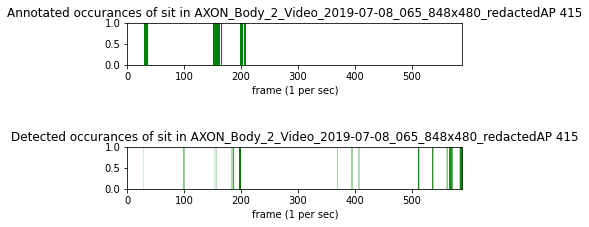

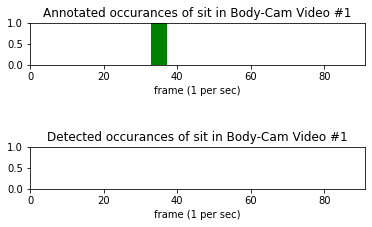

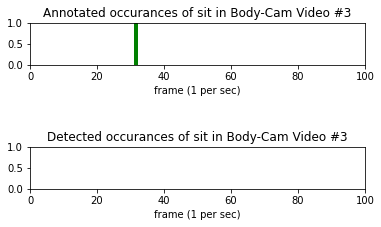

In [9]:
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
# load gt annos
with open(POBCA_PATH) as f:                                                                                                                                                       
    bwc_annos = json.load(f)
# get predicted boxes and labels
#video_name = 'AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP 415.mp4'
class2idx = get_classes(AVA_CLS)
search_action = 'sit'
idx = [val for key, val in class2idx.items() if search_action in key][0]
print(idx)
for vid_annos in bwc_annos:
    title = vid_annos['data']['image_url'][0].split('/')[0]
    num_frames = len(vid_annos['data']['image_url'])
    if 'AXON' in title:
        title = title[:-4]+' 415.mp4'
    else:
        title = title.replace('_',  ' ')+'.mp4'
    pred_boxes = load_boxes_labels(title[:-4], PREDS_PATH)
    action_color_bar(search_action, idx, title[:-4], vid_annos, pred_boxes, num_frames)
